# Level Up: Analyzing Nintendo Game Sales Across Multiple Consoles

## Data Scraped and Compiled from the Following Wikipedia Pages:

#### List of Best-selling Nintendo Switch Video Games
#### List of Best-selling Nintendo Wii Video Games
#### List of Best-selling Nintendo 3DS Video Games
#### List of Best-selling Video Games

# Background

#### For decades, Nintendo has dominated the video game console and software markets. Introducing popular characters and titles like Mario and Pokemon to a global audience, Nintendo has valiantly competed against Sony (Playstation) and Microsoft (Xbox).

### As of FY 2021, Nintendo's Investor portal reported the following console sales:

#### Nintendo Switch: 85 million units
#### Nintendo 3DS: 76 million units
#### Nintendo Wii: 102 million units

### However, for gamers, the real excitment relates to the releases and sales of various video games.
### Therefore, this analysis will seek to analyze, individually and collectively, worldwide sales of games for Nintendo Switch, Nintendo 3Ds and Nintendo Wii. The analysis will conclude with a cross-console comparison to determine how Nintendo video game sales compare to competing developers, including emerging mobile platforms.   

In [1]:
import pandas as pd
import re 
import numpy as np
from pathlib import Path
import sqlite3 
from pandas.io.html import read_html
import seaborn as sns
import matplotlib.pyplot as plt
url = 'https://en.wikipedia.org/wiki/List_of_best-selling_Nintendo_Switch_video_games'

# Nintendo Switch

#### The data tables featured in this analysis were scraped with Pandas' read_html function. 

#### By inspecting the page element, it is apparent that these tables are of the 'wikitable' class. Pandas' read_html function expedites scraping, allowing me to download the entire table in one request. 

In [2]:
switch_wiki = read_html(url, attrs={'class':'wikitable'})
print('Extracted {num} wikitables'.format(num=len(switch_wiki)))

Extracted 1 wikitables


#### Wikipedia maintains its credibility by providing reference numbers whenever possible. However, this is a problem when attempting to wrangle and convert data. 

In [3]:
switch_wiki[0].head(3)

,No.,Title,Copies sold,As of,Release date[b],Genre(s),Developer(s),Publisher(s)
0,1,Mario Kart 8 Deluxe,35.39 million[8],"March 31, 2021","April 28, 2017",Kart racing,Nintendo EPD,Nintendo
1,2,Animal Crossing: New Horizons,32.63 million[8],"March 31, 2021","March 20, 2020",Social simulation,Nintendo EPD,Nintendo
2,3,Super Smash Bros. Ultimate,23.84 million[8],"March 31, 2021","December 7, 2018",Fighting,Bandai Namco StudiosSora Ltd.,Nintendo


In [4]:
nintendo_switch = switch_wiki[0]

In [5]:
del nintendo_switch['No.']

In [6]:
nintendo_switch.dtypes

Title              object
Copies sold        object
As of              object
Release date[b]    object
Genre(s)           object
Developer(s)       object
Publisher(s)       object
dtype: object

#### To fix the string data, I looped through the columns to detect and replace instances of reference boxes, special symbols and words like 'million.' 

In [11]:
for column in nintendo_switch.columns:
    nintendo_switch[column] = nintendo_switch[column].str.replace(r"\(.*\)", " ")
    nintendo_switch[column] = nintendo_switch[column].str.replace(r"\[.*\]", " ")
    nintendo_switch[column] = nintendo_switch[column].str.replace(r"million", " ")

In [12]:
nintendo_switch.head(3)

,Title,Copies sold,As of,Release date[b],Genre(s),Developer(s),Publisher(s)
0,Mario Kart 8 Deluxe,35.39,"March 31, 2021","April 28, 2017",Kart racing,Nintendo EPD,Nintendo
1,Animal Crossing: New Horizons,32.63,"March 31, 2021","March 20, 2020",Social simulation,Nintendo EPD,Nintendo
2,Super Smash Bros. Ultimate,23.84,"March 31, 2021","December 7, 2018",Fighting,Bandai Namco StudiosSora Ltd.,Nintendo


#### Once I converted the data to a format that I could work with, I renamed the columns to remove symbols like parentheses that might result in a syntax or key error later on in the analysis. 

In [13]:
nintendo_switch.rename(columns={'Release date[b]': 'Release_date'}, inplace=True)
nintendo_switch.rename(columns={'Genre(s)': 'Genre'}, inplace=True)
nintendo_switch.rename(columns={'Developer(s)': 'Developer'}, inplace=True)
nintendo_switch.rename(columns={'Publisher(s)': 'Publisher'}, inplace=True)
nintendo_switch.rename(columns={'As of': 'Latest_report'}, inplace=True)
nintendo_switch.rename(columns={'Copies sold': 'Copies_sold_millions'}, inplace=True)

In [14]:
nintendo_switch.head(3)

,Title,Copies_sold_millions,Latest_report,Release_date,Genre,Developer,Publisher
0,Mario Kart 8 Deluxe,35.39,"March 31, 2021","April 28, 2017",Kart racing,Nintendo EPD,Nintendo
1,Animal Crossing: New Horizons,32.63,"March 31, 2021","March 20, 2020",Social simulation,Nintendo EPD,Nintendo
2,Super Smash Bros. Ultimate,23.84,"March 31, 2021","December 7, 2018",Fighting,Bandai Namco StudiosSora Ltd.,Nintendo


In [21]:
nintendo_switch['Copies_sold_millions'] = nintendo_switch['Copies_sold_millions'].astype(float)
#nintendo_switch['Latest_report'] = pd.to_datetime(nintendo_switch['Latest_report'])
#nintendo_switch['Release_date'] = pd.to_datetime(nintendo_switch['Release_date'])

In [ ]:
nintendo_switch

In [ ]:
nintendo_switch.dtypes

In [22]:
nintendo_switch.to_csv('nintendo_switch_game_dat.csv', header=True, index=False)

In [23]:
nintendo_switch_csv = pd.read_csv('nintendo_switch_game_dat.csv')

In [24]:
Path('nintendo_switch_data.db').touch()
switch_conn = sqlite3.connect('nintendo_switch_data.db')
switch_c = switch_conn.cursor()

In [18]:
switch_c.execute('''CREATE TABLE nintendo_switch_tab (Title text, Copies_sold_millions real, Latest_report real, Release_date real, Genre text, Developer text, Publisher text)''')

In [25]:
nintendo_switch_csv.to_sql('nintendo_switch_tab', switch_conn, if_exists='append', index=False)

In [26]:
nintendo_switch_csv.dtypes

Title                    object
Copies_sold_millions    float64
Latest_report            object
Release_date             object
Genre                    object
Developer                object
Publisher                object
dtype: object

#### For the first query, I wanted to know how many Mario games were included on the Nintendo Switch best-seller list.
#### Fortunately, SQL's 'LIKE' command allows me to search for instances in which Mario appears at the beginning or end of a title. 

In [29]:
mario_query = pd.read_sql('''SELECT Title, Copies_sold_millions, Release_date FROM nintendo_switch 
WHERE Title LIKE '%Mario%' 
ORDER BY Copies_sold_millions DESC ''', switch_conn)
mario_query

,Title,Copies_sold_millions,Release_date
0,Mario Kart 8 Deluxe,35.39,2017-04-28
1,Super Mario Odyssey,20.83,2017-10-27
2,Super Mario Party,14.79,2018-10-05
3,New Super Mario Bros. U Deluxe,10.44,2019-01-11
4,Super Mario 3D All-Stars,9.01,2020-09-18
5,Super Mario Maker 2,7.15,2019-06-28
6,Super Mario 3D World + Bowser's Fury,5.59,2021-02-12
7,Paper Mario: The Origami King,3.12,2020-07-17
8,Mario Tennis Aces,3.06,2018-06-22
9,Mario + Rabbids Kingdom Battle,2.00,2017-08-29


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

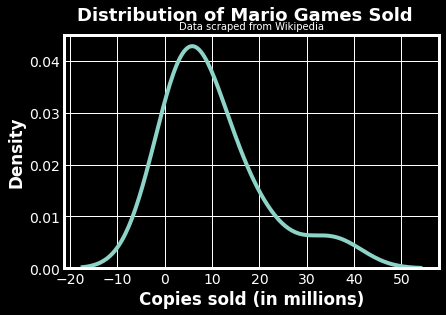

In [394]:
plt.style.use('dark_background')
plt.suptitle('Distribution of Mario Games Sold', weight='bold', color = 'white').set_fontsize(18)
plt.title('Data scraped from Wikipedia').set_fontsize(10)
sns.distplot(mario_query['Copies_sold_millions'], kde=True, hist=False)
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'white')
plt.ylabel('Density', weight = 'bold', color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')

In [416]:
mario_query['Copies_sold_millions'].describe()

count    11.000000
mean     10.240909
std      10.240615
min       1.270000
25%       3.090000
50%       7.150000
75%      12.615000
max      35.390000
Name: Copies_sold_millions, dtype: float64

#### The mean number of copies of Switch games with Mario in the title is approximately 10 million. The median value is approximately 7 million games sold. 

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


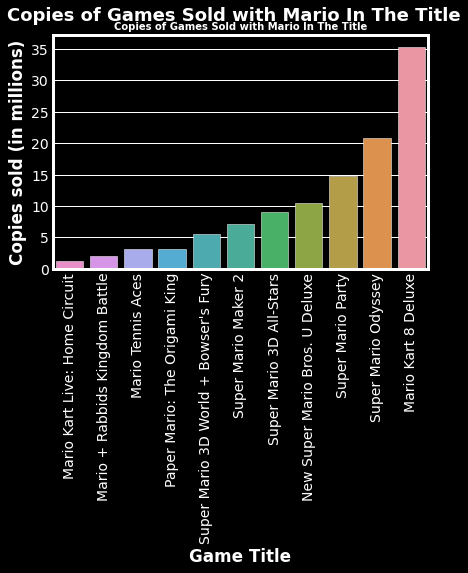

In [395]:
plt.style.use('dark_background')
sns.barplot(mario_query['Title'], mario_query['Copies_sold_millions'], edgecolor= 'white')
plt.suptitle('Copies of Games Sold with Mario In The Title', weight='bold').set_fontsize(18)
plt.title('Copies of Games Sold with Mario In The Title', weight='bold').set_fontsize(10)
plt.xlabel('Game Title', weight = 'bold', color = 'white')
plt.ylabel('Copies sold (in millions)', weight = 'bold', color = 'white')
plt.gca().invert_xaxis()
plt.xticks(rotation=90, color = 'white')
plt.yticks(color = 'white')
plt.show()

### The top three best-selling Mario games are:

#### Mario Kart 8: Deluxe (35 million)
#### Super Mario Odessy (22 million)
#### Super Mario Party (14 million)

In [31]:
poke_query = pd.read_sql('''SELECT Title, Copies_sold_millions, Release_date FROM nintendo_switch 
WHERE Title LIKE '%Pokémon%' OR Title LIKE '%Pokkén%' ORDER BY Copies_sold_millions DESC ''', switch_conn)

#### Aside from Mario, perhaps the most recognizable Nintendo title is the Pokémon franchise. 

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


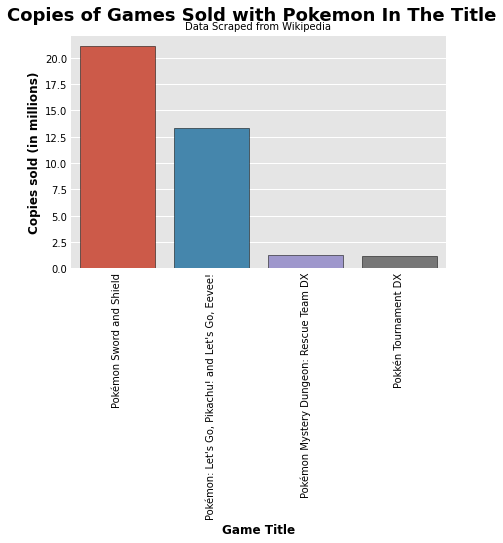

In [396]:
plt.style.use('ggplot')
sns.barplot(poke_query['Title'], poke_query['Copies_sold_millions'], edgecolor='black')
plt.suptitle('Copies of Games Sold with Pokemon In The Title', weight='bold', color = 'black').set_fontsize(18)
plt.title('Data Scraped from Wikipedia', color = 'black').set_fontsize(10)
plt.xlabel('Game Title', weight = 'bold', color = 'black')
plt.ylabel('Copies sold (in millions)', weight = 'bold', color = 'black')
#plt.gca().invert_xaxis()
plt.xticks(rotation=90, color = 'black')
plt.yticks(color = 'black')
plt.show()

In [418]:
poke_query['Copies_sold_millions'].describe()

count     4.000000
mean      9.200000
std       9.762882
min       1.160000
25%       1.235000
50%       7.270000
75%      15.235000
max      21.100000
Name: Copies_sold_millions, dtype: float64

#### The mean for Pokémon games sold is 9 million and the median is 7 million. While both the mean and median are comparable to the Mario game sales, the max values differ by nearly 15 million. Mario's best selling game sold 35 million copies while Pokémon's bestselling game sold 21 million copies. 

In [33]:
super_query = pd.read_sql('''SELECT Title, Copies_sold_millions, Release_date FROM nintendo_switch
WHERE Title LIKE '%Super%' ''', switch_conn)
super_query 

,Title,Copies_sold_millions,Release_date
0,Super Smash Bros. Ultimate,23.84,2018-12-07
1,Super Mario Odyssey,20.83,2017-10-27
2,Super Mario Party,14.79,2018-10-05
3,New Super Mario Bros. U Deluxe,10.44,2019-01-11
4,Super Mario 3D All-Stars,9.01,2020-09-18
5,Super Mario Maker 2,7.15,2019-06-28
6,Super Mario 3D World + Bowser's Fury,5.59,2021-02-12


#### As a Nintendo customer, I also noticed that several games contain 'Super' in the title. As an analyst, I wanted to determine whether Nintendo games with 'Super' in the title have a high volume of sales. 

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Copies sold (in millions)')

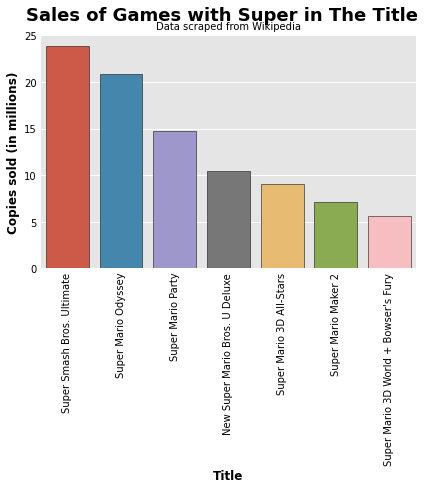

In [398]:
plt.suptitle('Sales of Games with Super in The Title', weight = 'bold', color = 'black').set_fontsize(18)
sns.barplot('Title', 'Copies_sold_millions', data = super_query, edgecolor='black')
plt.title('Data scraped from Wikipedia', color = 'black').set_fontsize(10)
plt.xlabel('Title', weight = 'bold', color = 'black')
plt.xticks(rotation=90, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Copies sold (in millions)', weight = 'bold', color = 'black')

#### My hypothesis was largely correct, as some of the Nintendo Switch's bestselling titles such as Super Smash Bros, Super Mario Odessy and Super Mario Party have sales that exceed 10 million copies. 

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

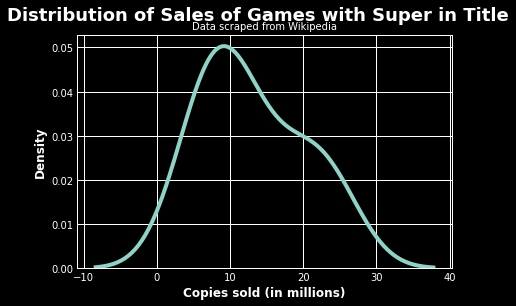

In [399]:
plt.style.use('dark_background')
plt.suptitle('Distribution of Sales of Games with Super in Title', weight='bold', color = 'white').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'white').set_fontsize(10)
sns.distplot(super_query['Copies_sold_millions'], kde=True, hist=False)
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'white')
plt.ylabel('Density', weight = 'bold', color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')

#### Unsurprsingly, the bestselling games for Switch were developed by Nintendo, with Mario Kart, Animal Crossing, and The Legend of Zelda comprising the top three best-selling Switch games. Interestingly, sales for Mario Kart and Animal Crossing are less than three million copies apart while there is a 10 million unit difference between sales for Animal Crossing and Zelda which is apparent in the bar chart below.  

In [421]:
nintendo_query = pd.read_sql(''' SELECT Title, Developer, Copies_sold_millions FROM
nintendo_switch WHERE Developer LIKE '%Nintendo%' ''', switch_conn)
nintendo_query.head(6)

,Title,Developer,Copies_sold_millions
0,Mario Kart 8 Deluxe,Nintendo EPD,35.39
1,Animal Crossing: New Horizons,Nintendo EPD,32.63
2,The Legend of Zelda: Breath of the Wild,Nintendo EPD,22.28
3,Super Mario Odyssey,Nintendo EPD,20.83
4,Splatoon 2,Nintendo EPD,12.21
5,New Super Mario Bros. U Deluxe,Nintendo EPD,10.44


Text(0, 0.5, 'Title')

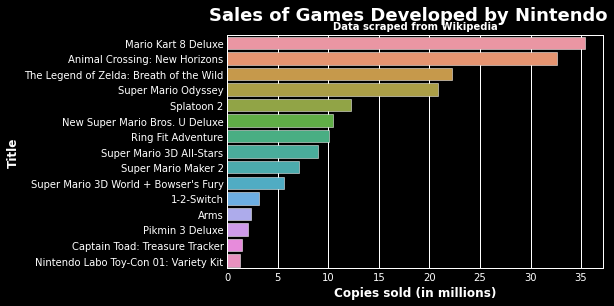

In [426]:
plt.style.use('dark_background')
plt.suptitle('Sales of Games Developed by Nintendo', color = 'white', weight = 'bold').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'white', weight = 'bold').set_fontsize(10)
plt.xticks(color = 'white')
plt.yticks(color = 'white')
sns.barplot(x = 'Copies_sold_millions', y = 'Title', data = nintendo_query, edgecolor='white')
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'white')
plt.ylabel('Title', weight = 'bold', color = 'white')

# Nintendo Wii

In [52]:
wii_url = 'https://en.wikipedia.org/wiki/List_of_best-selling_Wii_video_games'

In [53]:
wii_wiki_table = read_html(wii_url, attrs={'class':'wikitable'})
print('Extracted {num} wikitables'.format(num=len(wii_wiki_table)))

Extracted 2 wikitables


In [54]:
nintendo_wii = wii_wiki_table[1]

In [59]:
nintendo_wii.head(3)

,Game,Copies sold,Release date[a],Genre(s),Developer(s),Publisher(s)
0,Wii Sports,82.90,"November 19, 2006",Sports,Nintendo EAD,Nintendo
1,Mario Kart Wii,37.32,"April 10, 2008",Racing,Nintendo EAD,Nintendo
2,Wii Sports Resort,33.14,"June 25, 2009",Sports,Nintendo EAD,Nintendo


In [58]:
for column in nintendo_wii.columns:
    nintendo_wii[column] = nintendo_wii[column].str.replace(r"\(.*\)", " ")
    nintendo_wii[column] = nintendo_wii[column].str.replace(r"\[.*\]", " ")
    nintendo_wii[column] = nintendo_wii[column].str.replace(r"million", " ")
    nintendo_wii[column] = nintendo_wii[column].str.replace(r"†", " ")
    nintendo_wii[column] = nintendo_wii[column].str.replace(r"shipped", " ")
    nintendo_wii[column] = nintendo_wii[column].str.replace(r">", " ")

In [ ]:
nintendo_wii.tail(3)

In [60]:
nintendo_wii.rename(columns={'Copies sold': 'Copies_sold'}, inplace=True)
nintendo_wii.rename(columns={'Release date[a]': 'Release_date'}, inplace=True)
nintendo_wii.rename(columns={'Genre(s)': 'Genre'}, inplace=True)
nintendo_wii.rename(columns={'Developer(s)': 'Developer'}, inplace=True)
nintendo_wii.rename(columns={'Publisher(s)': 'Publisher'}, inplace=True)
nintendo_wii.rename(columns={'Copies_sold': 'Copies_sold_in_millions'}, inplace=True)

In [62]:
nintendo_wii.to_csv('nintendo.wii.csv', header=True, index=False)
nintendo_wii_csv = pd.read_csv('nintendo.wii.csv')
nintendo_wii_csv

,Game,Copies_sold_in_millions,Release_date,Genre,Developer,Publisher
0,Wii Sports,82.90,"November 19, 2006",Sports,Nintendo EAD,Nintendo
1,Mario Kart Wii,37.32,"April 10, 2008",Racing,Nintendo EAD,Nintendo
2,Wii Sports Resort,33.14,"June 25, 2009",Sports,Nintendo EAD,Nintendo
3,New Super Mario Bros. Wii,30.32,"November 12, 2009",Platform,Nintendo EAD,Nintendo
4,Wii Play,28.02,"December 2, 2006",Party,Nintendo EAD,Nintendo
...,...,...,...,...,...,...
58,Red Steel,1,"November 19, 2006",First-person shooter,Ubisoft Paris,Ubisoft
59,Rock Band,1,"June 22, 2008",Rhythm,Pi Studios,MTV GamesElectronic Arts
60,Zumba Fitness,1,"November 18, 2010",Fitness,Pipeworks Software,Majesco Entertainment505 Games
61,Super Mario Bros. 3,1,"November 5, 2007",Platform,Nintendo EAD,Nintendo


In [63]:
nintendo_wii_csv['Copies_sold_in_millions'] = nintendo_wii_csv['Copies_sold_in_millions'].astype(float)

In [ ]:
nintendo_wii_csv.dtypes

In [ ]:
nintendo_wii_csv.to_sql('nintendo_wii_games', switch_conn, if_exists='append', index=False)

In [ ]:
switch_c.execute('''CREATE TABLE nintendo_wii_games (Game text, Copies_sold_in_millions real, Release_date real, Genre text, Developer text, Publisher text)''')

In [64]:
wii = pd.read_sql(''' SELECT DISTINCT * FROM nintendo_wii_games  ''', switch_conn)
wii.dtypes

Game                        object
Copies_sold_in_millions    float64
Release_date                object
Genre                       object
Developer                   object
Publisher                   object
dtype: object

In [65]:
wii_game_sold_query = pd.read_sql(''' SELECT Game, Copies_sold_in_millions FROM nintendo_wii_games 
            GROUP BY Copies_sold_in_millions
            ORDER BY Game DESC
            LIMIT 10''', switch_conn)
wii_game_sold_query

,Game,Copies_sold_in_millions
0,Wii Sports Resort,33.14
1,Wii Sports,82.90
2,Wii Play: Motion,1.26
3,Wii Play,28.02
4,Wii Party,9.35
5,Wii Music,2.86
6,Wii Fit Plus,21.13
7,Wii Fit,22.67
8,WarioWare: Smooth Moves,2.35
9,Wario Land: Shake It!,1.06


In [ ]:
wii_game_sold_query.dtypes

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

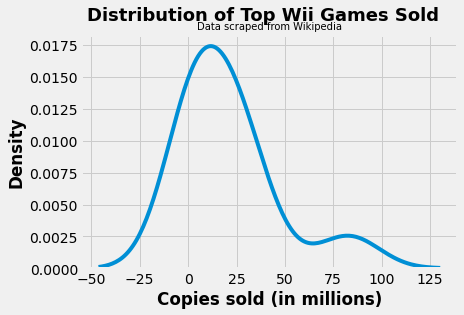

In [384]:
plt.style.use('fivethirtyeight')
plt.suptitle('Distribution of Top Wii Games Sold', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'black').set_fontsize(10)
sns.distplot(wii_game_sold_query['Copies_sold_in_millions'], kde=True, hist=False)
plt.xlabel('Copies sold (in millions)', color = 'black', weight = 'bold')
plt.ylabel('Density', color = 'black', weight = 'bold')
plt.xticks(color='black')
plt.yticks(color='black')

In [431]:
wii_game_sold_query['Copies_sold_in_millions'].describe()

count    10.000000
mean     20.474000
std      25.007076
min       1.060000
25%       2.477500
50%      15.240000
75%      26.682500
max      82.900000
Name: Copies_sold_in_millions, dtype: float64

#### Although the mean for the Wii is double that (20 million) of the Nintendo Switch (10 million), it is worth noting that the Wii is an older system overall, being released in 2011 compared to the Switch which was released in 2017. The median is also slightly higher than Nintendo Switch median sales, with 15 million copies sold.

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


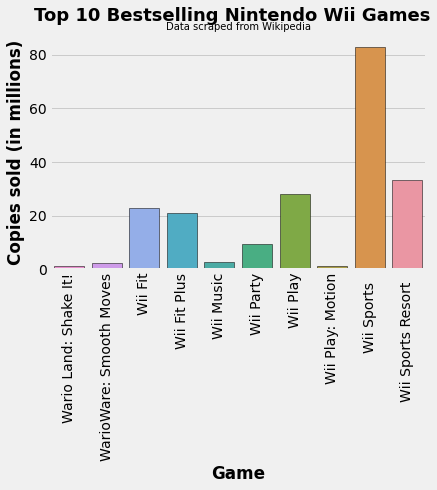

In [400]:
plt.style.use('fivethirtyeight')
plt.suptitle('Top 10 Bestselling Nintendo Wii Games', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color ='black').set_fontsize(10)
sns.barplot(wii_game_sold_query['Game'], wii_game_sold_query['Copies_sold_in_millions'], edgecolor='black')
plt.xlabel('Game', weight = 'bold', color = 'black')
plt.xticks(rotation=90, color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Copies sold (in millions)', weight = 'bold', color = 'black')
plt.gca().invert_xaxis()

In [70]:
mario_wii = pd.read_sql(''' SELECT Game, Copies_sold_in_millions FROM nintendo_wii_games
            WHERE Game LIKE '%Mario%' AND Developer LIKE '%Nintendo%'
            ORDER BY Game
            LIMIT 10''', switch_conn)
mario_wii

,Game,Copies_sold_in_millions
0,Mario Kart Wii,37.32
1,Mario Sports Mix,1.98
2,New Super Mario Bros. Wii,30.32
3,Super Mario All-Stars: 25th Anniversary Edition,2.24
4,Super Mario Bros. 3,1.00
5,Super Mario Galaxy,12.80
6,Super Mario Galaxy 2,7.41


In [432]:
mario_wii['Copies_sold_in_millions'].describe()

count     7.000000
mean     13.295714
std      14.738491
min       1.000000
25%       2.110000
50%       7.410000
75%      21.560000
max      37.320000
Name: Copies_sold_in_millions, dtype: float64

#### Like the Switch, Mario-related games are the most popular titles, with an average of 13 million copies sold. The most popular game, Mario Kart Wii, has sold the most copies (37 million) out of both the Switch and Wii data frames. 

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Mario Kart Wii  '),
  Text(0, 1, 'Mario Sports Mix'),
  Text(0, 2, 'New Super Mario Bros. Wii  '),
  Text(0, 3, 'Super Mario All-Stars: 25th Anniversary Edition'),
  Text(0, 4, 'Super Mario Bros. 3 '),
  Text(0, 5, 'Super Mario Galaxy'),
  Text(0, 6, 'Super Mario Galaxy 2')])

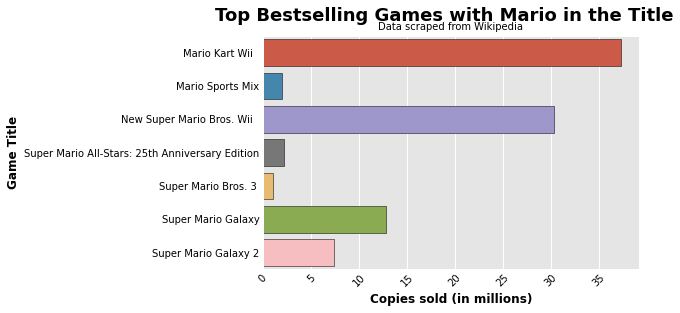

In [391]:
plt.style.use('ggplot')
plt.suptitle('Top Bestselling Games with Mario in the Title', weight='bold', color='black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color='black').set_fontsize(10)
sns.barplot('Copies_sold_in_millions', 'Game', data = mario_wii, edgecolor='black', orient='h')
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'black')
plt.ylabel('Game Title', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')

In [81]:
pd.read_sql(''' SELECT DISTINCT Game, Copies_sold_in_millions FROM nintendo_wii
            WHERE Game LIKE '%Poké%'
            ORDER BY Copies_sold_in_millions DESC ''', switch_conn)

,Game,Copies_sold_in_millions
0,Pokémon Battle Revolution,1.95
1,PokéPark Wii: Pikachu's Adventure,1.25


#### Unlike the Nintendo Switch, Pokémon games were among the least popular Wii titles sold at less than 2 million copies each. 

In [82]:
wii_name_query = pd.read_sql(''' SELECT DISTINCT Game, Copies_sold_in_millions FROM nintendo_wii_games
            WHERE GAME LIKE '%Wii%'
            ORDER BY Game DESC
            LIMIT 10''', switch_conn)
wii_name_query

,Game,Copies_sold_in_millions
0,Wii Sports Resort,33.14
1,Wii Sports,82.90
2,Wii Play: Motion,1.26
3,Wii Play,28.02
4,Wii Party,9.35
5,Wii Music,2.86
6,Wii Fit Plus,21.13
7,Wii Fit,22.67
8,Resident Evil 4: Wii Edition,2.00
9,PokéPark Wii: Pikachu's Adventure,1.25


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

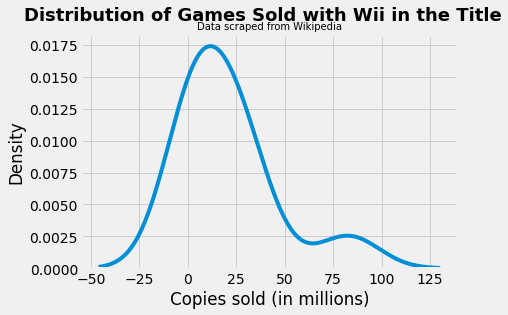

In [366]:
plt.style.use('fivethirtyeight')
plt.suptitle('Distribution of Games Sold with Wii in the Title', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'black').set_fontsize(10)
sns.distplot(wii_name_query['Copies_sold_in_millions'], kde=True, hist=False)
plt.xlabel('Copies sold (in millions)', color = 'black')
plt.ylabel('Density', color = 'black')
plt.xticks(color='black')
plt.yticks(color='black')

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Wii Sports Resort  '),
  Text(0, 1, 'Wii Sports  '),
  Text(0, 2, 'Wii Play: Motion'),
  Text(0, 3, 'Wii Play'),
  Text(0, 4, 'Wii Party'),
  Text(0, 5, 'Wii Music'),
  Text(0, 6, 'Wii Fit Plus'),
  Text(0, 7, 'Wii Fit'),
  Text(0, 8, 'Resident Evil 4: Wii Edition'),
  Text(0, 9, "PokéPark Wii: Pikachu's Adventure")])

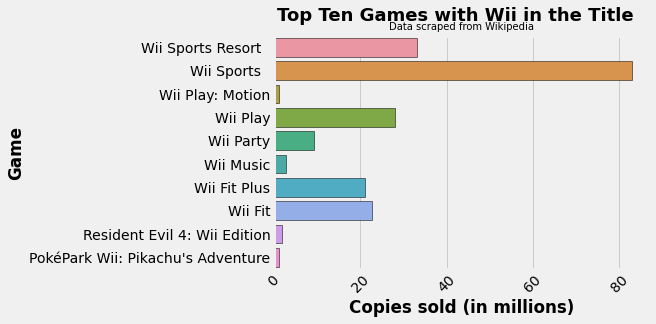

In [403]:
plt.suptitle('Top Ten Games with Wii in the Title', weight='bold', color='black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color='black').set_fontsize(10)
sns.barplot('Copies_sold_in_millions', 'Game', data = wii_name_query, edgecolor='black', orient='h')
plt.ylabel('Game', weight = 'bold', color = 'black')
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'black')
plt.xticks(rotation=45, color = 'black')
plt.yticks(color = 'black')

In [433]:
wii_name_query['Copies_sold_in_millions'].describe()

count    10.000000
mean     20.458000
std      25.019216
min       1.250000
25%       2.215000
50%      15.240000
75%      26.682500
max      82.900000
Name: Copies_sold_in_millions, dtype: float64

#### Games with the word 'Wii' in them sold the best out of all Wii titles. Both the mean (20 million) and max values (83 million) are higher than any other title sold for the Wii. The max value is more than double that of the maximum number of the bestselling Nintendo Switch game, Mario Kart 8. 

In [87]:
genre_percent = pd.read_sql(''' SELECT Genre, COUNT(Genre) AS Game_count,
            COUNT(Genre) * 100.0 / (SELECT COUNT(*) FROM nintendo_wii_games) AS Genre_percent
            FROM nintendo_wii_games
            GROUP BY Genre
            ORDER BY Genre_percent DESC
            LIMIT 15
            ''', switch_conn)

In [88]:
genre_percent

,Genre,Game_count,Genre_percent
0,Sports,13,20.634921
1,Platform,10,15.873016
2,Party,8,12.698413
3,Rhythm,4,6.349206
4,Action-adventure,4,6.349206
5,Exergaming,3,4.761905
6,Music: rhythm,2,3.174603
7,Fitness,2,3.174603
8,First-person shooter,2,3.174603
9,Fighting,2,3.174603


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Sports'),
  Text(1, 0, 'Platform'),
  Text(2, 0, 'Party'),
  Text(3, 0, 'Rhythm'),
  Text(4, 0, 'Action-adventure'),
  Text(5, 0, 'Exergaming'),
  Text(6, 0, 'Music: rhythm'),
  Text(7, 0, 'Fitness'),
  Text(8, 0, 'First-person shooter'),
  Text(9, 0, 'Fighting'),
  Text(10, 0, 'Survival horror'),
  Text(11, 0, 'Shooter'),
  Text(12, 0, 'Rail shooter'),
  Text(13, 0, 'Racing'),
  Text(14, 0, 'Puzzle: educational')])

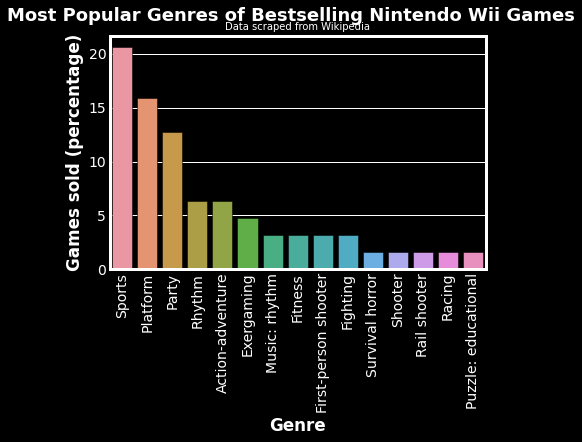

In [406]:
plt.style.use('dark_background')
sns.barplot(genre_percent['Genre'], genre_percent['Genre_percent'], edgecolor='black')
plt.suptitle('Most Popular Genres of Bestselling Nintendo Wii Games', weight = 'bold').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color='white').set_fontsize(10)
plt.ylabel('Games sold (percentage)', weight = 'bold', color = 'white')
plt.xlabel('Genre', weight = 'bold', color = 'white')
plt.xticks(rotation=90)

#### The most popular genre for Wii games, Sports, is notable because the Wii harnesses motion capture technology for many titles. Its most popular release, Wii Sports, initially accompanied the sale of the Wii console, which may account for the boost in sales within the sports genre. 

In [428]:
pub_percent = pd.read_sql(''' SELECT Publisher, COUNT(Publisher) AS Games_published,
            COUNT(Publisher) * 100.0 / (SELECT COUNT(*) FROM nintendo_wii_games) AS Percent_published
            FROM nintendo_wii_games
            GROUP BY Publisher
            ORDER BY Percent_published DESC
            LIMIT 5 ''', switch_conn)
pub_percent

,Publisher,Games_published,Percent_published
0,Nintendo,35,55.555556
1,Ubisoft,6,9.523810
2,JP: NintendoNA/PAL: Sega,3,4.761905
3,Activision,3,4.761905
4,Midway Games,2,3.174603


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0., 10., 20., 30., 40., 50., 60.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

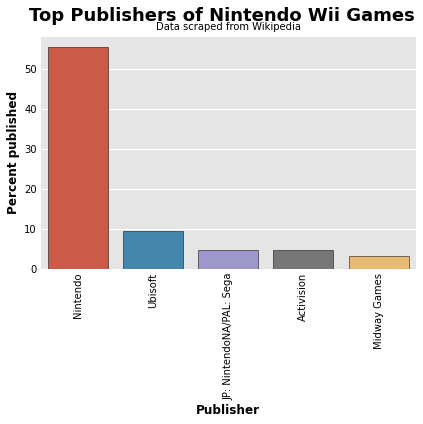

In [429]:
plt.style.use('ggplot')
sns.barplot(pub_percent['Publisher'], pub_percent['Percent_published'], edgecolor='black')
plt.suptitle('Top Publishers of Nintendo Wii Games', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'black').set_fontsize(10)
plt.ylabel('Percent published', weight = 'bold', color = 'black')
plt.xlabel('Publisher', weight = 'bold', color = 'black')
plt.xticks(rotation=90, color = 'black')
plt.yticks(color = 'black')

#### Unsurprisingly, Nintendo is the primary publisher of games for the Wii. Ubisoft and Activision both publish cross-console titles such as Call of Duty and Assassin's Creed, franchises that can be played on the Wii, Xbox and Playstation.   

# Nintendo 3DS

In [95]:
three_ds_url = 'https://en.wikipedia.org/wiki/List_of_best-selling_Nintendo_3DS_video_games'

In [96]:
three_ds_table = read_html(three_ds_url, attrs={'class': 'wikitable'})
print('Extracted {num} wikitables'.format(num=len(three_ds_table)))

Extracted 1 wikitables


In [97]:
three_ds_table[0].head(3)

,No.,Game,Copies sold,As of,Release date[a],Genre(s),Developer(s),Publisher(s)
0,1,Mario Kart 7,18.94 million[2],"September 30, 2020","December 1, 2011",Racing,Nintendo EADRetro Studios,Nintendo
1,2,Pokémon X and Y,16.53 million[2],"September 30, 2020","October 12, 2013",Role-playing,Game Freak,The Pokémon CompanyNintendo
2,3,Pokémon Sun and Moon,16.25 million[2],"September 30, 2020","November 18, 2016",Role-playing,Game Freak,The Pokémon CompanyNintendo


In [98]:
three_ds_table = three_ds_table[0]

In [99]:
del three_ds_table['No.']

In [100]:
for column in three_ds_table.columns:
    three_ds_table[column] = three_ds_table[column].str.replace(r"\(.*\)", " ")
    three_ds_table[column] = three_ds_table[column].str.replace(r"\[.*\]", " ")
    three_ds_table[column] = three_ds_table[column].str.replace(r"million", " ")

In [101]:
three_ds_table.rename(columns={'Copies sold': 'Copies_sold_in_millions', 'Release date[a]': 'Release date',
                              'Genre(s)': 'Genre', 'Developer(s)': 'Developer', 'Publisher(s)': 'Publisher'},
                     inplace=True)

In [ ]:
three_ds_table.head(3)

In [102]:
three_ds_table.rename(columns={'As of': 'Report_date', 'Release date': 'Release_date', 'Game': 'Title'}, inplace=True)

In [103]:
three_ds_table.to_csv('three.ds.csv', index=False, header=True)

In [110]:
#three_ds_table['Release_date'] = pd.to_datetime(three_ds_table['Release_date'])
three_ds_table_csv['Copies_sold_in_millions'] = three_ds_table_csv['Copies_sold_in_millions'].astype(float)

In [114]:
three_ds_table_csv = pd.read_csv('three.ds.csv')
three_ds_table_csv.head(3)

,Title,Copies_sold_in_millions,Report_date,Release_date,Genre,Developer,Publisher
0,Mario Kart 7,18.94,"September 30, 2020","December 1, 2011",Racing,Nintendo EADRetro Studios,Nintendo
1,Pokémon X and Y,16.53,"September 30, 2020","October 12, 2013",Role-playing,Game Freak,The Pokémon CompanyNintendo
2,Pokémon Sun and Moon,16.25,"September 30, 2020","November 18, 2016",Role-playing,Game Freak,The Pokémon CompanyNintendo


In [115]:
del three_ds_table_csv['Report_date']

In [116]:
three_ds_table_csv.dtypes

Title                      object
Copies_sold_in_millions    object
Release_date               object
Genre                      object
Developer                  object
Publisher                  object
dtype: object

In [117]:
three_ds_table_csv.to_sql('three_ds_dat', switch_conn, if_exists='append', index=False)

In [175]:
three_d = pd.read_sql(''' SELECT * FROM three_ds_dat  ''', switch_conn)
three_d

,Title,Copies_sold_in_millions,Release_date,Genre,Developer,Publisher
0,Mario Kart 7,18.94,2011-12-01,Racing,Nintendo EADRetro Studios,Nintendo
1,Pokémon X and Y,16.53,2013-10-12,Role-playing,Game Freak,The Pokémon CompanyNintendo
2,Pokémon Sun and Moon,16.25,2016-11-18,Role-playing,Game Freak,The Pokémon CompanyNintendo
3,Pokémon Omega Ruby and Alpha Sapphire,14.39,2014-11-21,Role-playing,Game Freak,The Pokémon CompanyNintendo
4,New Super Mario Bros. 2,13.38,2012-07-28,Platform,Nintendo EAD,Nintendo
...,...,...,...,...,...,...
109,Bravely Default,1,"October 11, 2012",Role-playing,Silicon Studio,Nintendo
110,Fantasy Life,1,"December 27, 2012",Role-playing,Level-5,JP: Level-5WW: Nintendo
111,Monster Strike,1,"December 17, 2015",Role-playing,Mixi,Xflag
112,Rhythm Heaven Megamix,1,"June 11, 2015",Rhythm,Nintendo SPD,Nintendo


In [442]:
pop_ten_three_ds = pd.read_sql(''' SELECT Title, Copies_sold_in_millions
                FROM three_ds_dat
                GROUP BY Title
                ORDER BY Copies_sold_in_millions DESC
                LIMIT 10''', switch_conn)
pop_ten_three_ds.head(3)

,Title,Copies_sold_in_millions
0,Mario Kart 7,18.94
1,Pokémon X and Y,16.53
2,Pokémon Sun and Moon,16.25


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

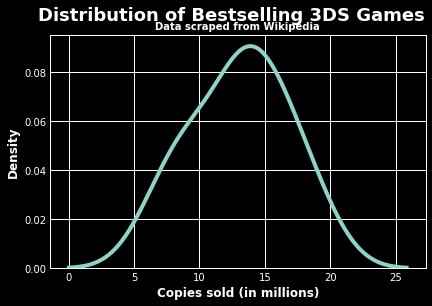

In [449]:
plt.style.use('dark_background')
plt.suptitle('Distribution of Bestselling 3DS Games', weight = 'bold', color = 'white').set_fontsize(18)
plt.title('Data scraped from Wikipedia', weight = 'bold', color = 'white').set_fontsize(10)
sns.distplot(pop_ten_three_ds['Copies_sold_in_millions'], kde=True, hist=False)
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'white')
plt.ylabel('Density', weight = 'bold', color = 'white')
plt.xticks(color = 'white')
plt.yticks(color = 'white')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Mario Kart 7'),
  Text(0, 1, 'Pokémon X and Y'),
  Text(0, 2, 'Pokémon Sun and Moon'),
  Text(0, 3, 'Pokémon Omega Ruby and Alpha Sapphire'),
  Text(0, 4, 'New Super Mario Bros. 2'),
  Text(0, 5, 'Animal Crossing: New Leaf'),
  Text(0, 6, 'Super Mario 3D Land'),
  Text(0, 7, 'Super Smash Bros. for Nintendo 3DS'),
  Text(0, 8, 'Pokémon Ultra Sun and Ultra Moon'),
  Text(0, 9, 'Yo-kai Watch 2')])

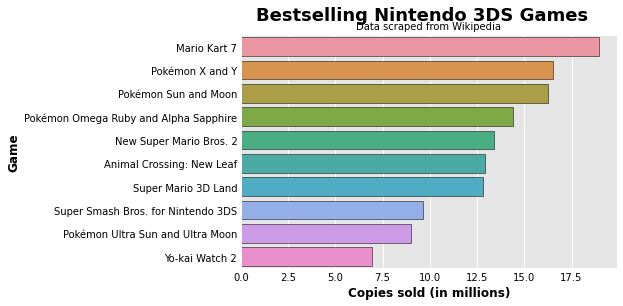

In [443]:
plt.style.use('ggplot')
plt.suptitle('Bestselling Nintendo 3DS Games', weight = 'bold', color = 'black').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'black').set_fontsize(10)
sns.barplot(x = 'Copies_sold_in_millions', y = 'Title', data = pop_ten_three_ds, edgecolor = 'black')
plt.xlabel('Copies sold (in millions)', weight = 'bold', color = 'black')
plt.ylabel('Game', weight = 'bold', color = 'black')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

#### Notably, nearly every title on the bestselling list is part of a franchise, such as Mario and Pokémon. 

In [452]:
three_ds_genre = pd.read_sql(''' SELECT Genre, COUNT(Genre) AS Count_Genre,
                                 COUNT(Genre) * 100 / (SELECT COUNT(*) FROM three_ds_dat) AS Genre_Percent
                                 FROM three_ds_dat
                                 GROUP BY Genre
                                 ORDER BY Genre_Percent DESC
                                 LIMIT 10
                                 ''', switch_conn)
three_ds_genre

,Genre,Count_Genre,Genre_Percent
0,Role-playing,36,31
1,Action-adventure,12,10
2,Action role-playing,12,10
3,Platform,8,7
4,Life simulation,6,5
5,Tactical role-playing,4,3
6,Roguelike,4,3
7,Fighting,4,3
8,Actionplatform,4,3
9,Third-person shootershoot 'em up,2,1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Role-playing'),
  Text(0, 1, 'Action-adventure'),
  Text(0, 2, 'Action role-playing'),
  Text(0, 3, 'Platform'),
  Text(0, 4, 'Life simulation'),
  Text(0, 5, 'Tactical role-playing'),
  Text(0, 6, 'Roguelike'),
  Text(0, 7, 'Fighting'),
  Text(0, 8, 'Actionplatform'),
  Text(0, 9, "Third-person shootershoot 'em up")])

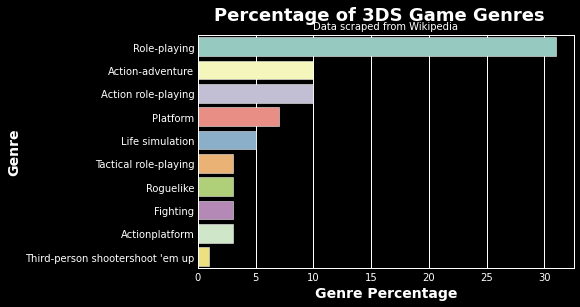

In [458]:
plt.style.use('dark_background')
plt.suptitle('Percentage of 3DS Game Genres', weight = 'bold', color = 'white').set_fontsize(18)
plt.title('Data scraped from Wikipedia').set_fontsize(10)
sns.barplot(x = 'Genre_Percent', y = 'Genre', data = three_ds_genre, edgecolor='white')
plt.xlabel('Genre Percentage', weight = 'bold', color = 'white').set_fontsize(14)
plt.ylabel('Genre', weight = 'bold', color = 'white').set_fontsize(14)
plt.xticks(color = 'white')
plt.yticks(color = 'white')

#### Although the difference between the action-adventure and action role-playing genres is minimal, the role-playing genre encompasses some of the most popular games of the last five years such as the Pokémon franchise which has released several games for both iterations of the DS system, the DS and 3DS. 

#### I used a left join on the scraped data in order to build a larger database that includes all the existing Wii database entries and information related to games sold on multiple Nintendo and non-Nintendo consoles.

In [177]:
#nintendo_wii_games
#three_ds_dat
three_wii = pd.read_sql(''' SELECT * FROM three_ds_dat
                LEFT JOIN nintendo_wii_games
                ON three_ds_dat.Title = nintendo_wii_games.Game ''', switch_conn)
three_wii

,Title,Copies_sold_in_millions,Release_date,Genre,Developer,Publisher,Game,Copies_sold_in_millions,Release_date,Genre,Developer,Publisher
0,Mario Kart 7,18.94,2011-12-01,Racing,Nintendo EADRetro Studios,Nintendo,None,None,None,None,None,None
1,Pokémon X and Y,16.53,2013-10-12,Role-playing,Game Freak,The Pokémon CompanyNintendo,None,None,None,None,None,None
2,Pokémon Sun and Moon,16.25,2016-11-18,Role-playing,Game Freak,The Pokémon CompanyNintendo,None,None,None,None,None,None
3,Pokémon Omega Ruby and Alpha Sapphire,14.39,2014-11-21,Role-playing,Game Freak,The Pokémon CompanyNintendo,None,None,None,None,None,None
4,New Super Mario Bros. 2,13.38,2012-07-28,Platform,Nintendo EAD,Nintendo,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
109,Bravely Default,1,"October 11, 2012",Role-playing,Silicon Studio,Nintendo,None,None,None,None,None,None
110,Fantasy Life,1,"December 27, 2012",Role-playing,Level-5,JP: Level-5WW: Nintendo,None,None,None,None,None,None
111,Monster Strike,1,"December 17, 2015",Role-playing,Mixi,Xflag,None,None,None,None,None,None
112,Rhythm Heaven Megamix,1,"June 11, 2015",Rhythm,Nintendo SPD,Nintendo,None,None,None,None,None,None


# Bestsellers

In [226]:
best_seller_url = 'https://en.wikipedia.org/wiki/List_of_best-selling_video_games'
best_seller = read_html(best_seller_url, attrs={'class':'wikitable'})
print('Extracted {num} wiki tables'.format(num=len(best_seller)))

Extracted 1 wiki tables


In [227]:
best_seller_list = best_seller[0]

In [228]:
best_seller_list.tail(3)

,Rank,Title,Sales,Platform(s),Initial release date,Developer(s)[a],Publisher(s)[a],Ref(s).
49,49,The Sims 4,20000000,Multi-platform,"September 2, 2014",Maxis,Electronic Arts,[53]
50,49,The Last of Us / Remastered,20000000,PS3 / PS4,"June 14, 2013",Naughty Dog,Sony Computer Entertainment,[54]
51,49,Marvel's Spider-Man / Remastered,20000000,PS4 / PS5,"September 7, 2018",Insomniac Games,Sony Interactive Entertainment,[55][56]


In [229]:
best_seller_list.dtypes

Rank                     int64
Title                   object
Sales                   object
Platform(s)             object
Initial release date    object
Developer(s)[a]         object
Publisher(s)[a]         object
Ref(s).                 object
dtype: object

In [230]:
del best_seller_list['Ref(s).']

In [231]:
del best_seller_list['Rank']

In [244]:
for column in best_seller_list.columns:
    best_seller_list[column] = best_seller_list[column].str.replace(r"\(.*\)", " ")
    best_seller_list[column] = best_seller_list[column].str.replace(r"\[.*\]", " ")
    best_seller_list[column] = best_seller_list[column].str.replace(r',', ' ')
    best_seller_list[column] = best_seller_list[column].str.replace(r" ", '')

In [245]:
best_seller_list.head(3)

,Title,Sales,Platform,Initial release date,Developer,Publisher
0,Minecraft,200000000,Multi-platform,November182011,MojangStudios,XboxGameStudios
1,GrandTheftAutoV,145000000,Multi-platform,September172013,RockstarNorth,RockstarGames
2,Tetris,100000000,Mobile,September122006,EAMobile,ElectronicArts


In [236]:
best_seller_list.rename(columns={'Platform(s)': 'Platform', 
                                 'Developer(s)[a]': 'Developer', 'Publisher(s)[a]': 'Publisher'},
                       inplace=True)

In [252]:
best_seller_list.head(3)

,Title,Sales,Platform,Initial release date,Developer,Publisher
0,Minecraft,200.0,Multi-platform,November182011,MojangStudios,XboxGameStudios
1,GrandTheftAutoV,145.0,Multi-platform,September172013,RockstarNorth,RockstarGames
2,Tetris,100.0,Mobile,September122006,EAMobile,ElectronicArts


In [247]:
best_seller_list['Sales'] = best_seller_list['Sales'].astype(int)

In [250]:
best_seller_list['Sales'] = best_seller_list['Sales'].div(1000).round(2)

In [253]:
best_seller_list.rename(columns={'Sales': 'Sales_in_millions'}, inplace=True)

In [258]:
best_seller_list.to_csv('best_selling_video_games.csv')
best_selling_games = pd.read_csv('best_selling_video_games.csv')

In [259]:
best_selling_games.head(3)

,Unnamed: 0,Title,Sales_in_millions,Platform,Initial release date,Developer,Publisher
0,0,Minecraft,200.0,Multi-platform,November182011,MojangStudios,XboxGameStudios
1,1,GrandTheftAutoV,145.0,Multi-platform,September172013,RockstarNorth,RockstarGames
2,2,Tetris,100.0,Mobile,September122006,EAMobile,ElectronicArts


In [260]:
del best_selling_games['Unnamed: 0']

In [261]:
best_selling_games.head(3)

,Title,Sales_in_millions,Platform,Initial release date,Developer,Publisher
0,Minecraft,200.0,Multi-platform,November182011,MojangStudios,XboxGameStudios
1,GrandTheftAutoV,145.0,Multi-platform,September172013,RockstarNorth,RockstarGames
2,Tetris,100.0,Mobile,September122006,EAMobile,ElectronicArts


In [262]:
best_selling_games.to_sql('best_selling_video_games', switch_conn, if_exists='append', index=False)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [271]:
best_sell = pd.read_sql(''' SELECT * FROM nintendo_wii_games
                LEFT JOIN best_selling_video_games
                ON best_selling_video_games.Sales_in_millions = nintendo_wii_games.Copies_sold_in_millions
                ''', switch_conn)
best_sell

,Game,Copies_sold_in_millions,Release_date,Genre,Developer,Publisher,Title,Sales_in_millions,Platform,Initial release date,Developer,Publisher
0,Wii Sports,82.90,"November 19, 2006",Sports,Nintendo EAD,Nintendo,WiiSports,82.90,Wii,November192006,NintendoEAD,Nintendo
1,Mario Kart Wii,37.32,"April 10, 2008",Racing,Nintendo EAD,Nintendo,None,NaN,None,None,None,None
2,Wii Sports Resort,33.14,"June 25, 2009",Sports,Nintendo EAD,Nintendo,WiiSportsResort,33.14,Wii,June252009,NintendoEAD,Nintendo
3,New Super Mario Bros. Wii,30.32,"November 12, 2009",Platform,Nintendo EAD,Nintendo,NewSuperMarioBros.Wii,30.32,Wii,November112009,NintendoEAD,Nintendo
4,Wii Play,28.02,"December 2, 2006",Party,Nintendo EAD,Nintendo,WiiPlay,28.02,Wii,December22006,NintendoEAD,Nintendo
...,...,...,...,...,...,...,...,...,...,...,...,...
58,Red Steel,1.00,"November 19, 2006",First-person shooter,Ubisoft Paris,Ubisoft,None,NaN,None,None,None,None
59,Rock Band,1.00,"June 22, 2008",Rhythm,Pi Studios,MTV GamesElectronic Arts,None,NaN,None,None,None,None
60,Zumba Fitness,1.00,"November 18, 2010",Fitness,Pipeworks Software,Majesco Entertainment505 Games,None,NaN,None,None,None,None
61,Super Mario Bros. 3,1.00,"November 5, 2007",Platform,Nintendo EAD,Nintendo,None,NaN,None,None,None,None


#### In order to more seamlessly merge the Wii and bestselling data, I used the intersect and union commands. 
#### The resulting database contains common columns such as copies sold in millions, release date, genre and developer. 

In [272]:
best_sell_wii = pd.read_sql(''' SELECT * FROM nintendo_wii_games
                                UNION 
                                SELECT * FROM best_selling_video_games
                                EXCEPT
                                SELECT * FROM nintendo_wii_games
                                INTERSECT
                                SELECT * FROM best_selling_video_games''', switch_conn)
best_sell_wii

,Game,Copies_sold_in_millions,Release_date,Genre,Developer,Publisher
0,AnimalCrossing:NewHorizons,32.63,NintendoSwitch,March202020,NintendoEPD,Nintendo
1,Borderlands2,22.00,Multi-platform,September182012,GearboxSoftware,2KGames
2,CallofDuty:BlackOps,26.20,Multi-platform,November92010,Treyarch,Activision
3,CallofDuty:BlackOpsII,24.20,Multi-platform,November122012,Treyarch,Activision
4,CallofDuty:ModernWarfare,30.00,Multi-platform,October252019,InfinityWard,Activision
5,CallofDuty:ModernWarfare2,22.70,Multi-platform,November102009,InfinityWard,Activision
6,CallofDuty:ModernWarfare3,26.50,Multi-platform,November82011,InfinityWard/Sledgehammer,Activision
7,DiabloIII/ReaperofSouls,30.00,Multi-platform,May162012,BlizzardEntertainment,BlizzardEntertainment
8,DuckHunt,28.30,NES,April211984,NintendoR&D1,Nintendo
9,FIFA18,24.00,Multi-platform,September292017,EACanada,ElectronicArts


In [273]:
del best_sell_wii['Genre']

In [274]:
del best_sell_wii['Release_date']

In [299]:
best_sell_wii.head(3)

,Game,Copies_sold_in_millions,Developer,Publisher
0,AnimalCrossing:NewHorizons,32.63,NintendoEPD,Nintendo
1,Borderlands2,22.00,GearboxSoftware,2KGames
2,CallofDuty:BlackOps,26.20,Treyarch,Activision


In [308]:
all_three_consoles = pd.read_sql(''' SELECT Title, Platform, Sales_in_millions FROM best_selling_video_games
                WHERE Platform = 'Wii' OR Platform = 'Nintendo3DS' OR Platform = 'NintendoSwitch'
                GROUP BY Title
                ORDER BY Sales_in_millions DESC
                ''', switch_conn)
all_three_consoles

,Title,Platform,Sales_in_millions
0,WiiSports,Wii,82.90
1,WiiFit/Plus,Wii,43.80
2,MarioKartWii,Wii,37.38
3,WiiSportsResort,Wii,33.14
4,AnimalCrossing:NewHorizons,NintendoSwitch,32.63
5,NewSuperMarioBros.Wii,Wii,30.32
6,WiiPlay,Wii,28.02
7,PokémonSun/Moon/UltraSun/UltraMoon,Nintendo3DS,25.09
8,SuperSmashBros.Ultimate,NintendoSwitch,23.84
9,PokémonSword/Shield,NintendoSwitch,21.10


#### Filtering by platform allowed me to examine records that are common between Wii, Nintendo 3DS, and Switch. Even examining the above table, it is evident that the Wii has the most sales of all three consoles by nearly 30 million. Again, it is worth mentioning that the Wii is the oldest of the three systems. 

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'WiiSports'),
  Text(0, 1, 'WiiFit/Plus'),
  Text(0, 2, 'MarioKartWii'),
  Text(0, 3, 'WiiSportsResort'),
  Text(0, 4, 'AnimalCrossing:NewHorizons'),
  Text(0, 5, 'NewSuperMarioBros.Wii'),
  Text(0, 6, 'WiiPlay'),
  Text(0, 7, 'PokémonSun/Moon/UltraSun/UltraMoon'),
  Text(0, 8, 'SuperSmashBros.Ultimate'),
  Text(0, 9, 'PokémonSword/Shield'),
  Text(0, 10, 'SuperMarioOdyssey')])

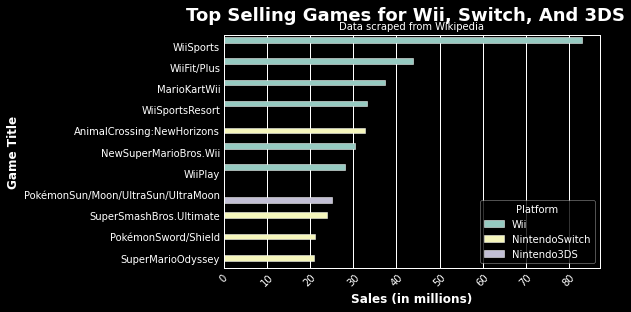

In [409]:
plt.style.use('dark_background')
sns.barplot('Sales_in_millions', 'Title', 'Platform', data = all_three_consoles, edgecolor='white')
plt.suptitle('Top Selling Games for Wii, Switch, And 3DS', weight='bold', color = 'white').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color='white').set_fontsize(10)
plt.xlabel('Sales (in millions)', weight = 'bold', color = 'white')
plt.ylabel('Game Title', weight = 'bold', color = 'white')
plt.xticks(rotation=45, color = 'white')
plt.yticks(color = 'white')

#### Like the previous queries, the most popular games sold included the key words 'Wii' and 'Mario.' Wii Sports, and Wii Fit Plus, both entries in the sports genre, are the most popular games sold across platforms. Nintendo's decision to include Wii Sports with its initial console sales in 2011 resulted in sales that double the second-most bestselling game, Wii Fit Plus. 

In [335]:
all_nintendo_consoles = pd.read_sql(''' SELECT Title, Platform, Sales_in_millions
                                         FROM best_selling_video_games
                                         WHERE Publisher = 'Nintendo'
                                         GROUP BY Title
                                         ORDER BY Sales_in_millions DESC
                                         LIMIT 11''',
                                    switch_conn)
all_nintendo_consoles

,Title,Platform,Sales_in_millions
0,WiiSports,Wii,82.90
1,SuperMarioBros.,NES/Arcade,58.00
2,PokémonRed/Green/Blue/Yellow,GameBoy/Color,47.52
3,MarioKart8/Deluxe,WiiU/Switch,43.84
4,WiiFit/Plus,Wii,43.80
5,Tetris,GameBoy/NES,43.00
6,MarioKartWii,Wii,37.38
7,WiiSportsResort,Wii,33.14
8,AnimalCrossing:NewHorizons,NintendoSwitch,32.63
9,NewSuperMarioBros.,NintendoDS,30.80


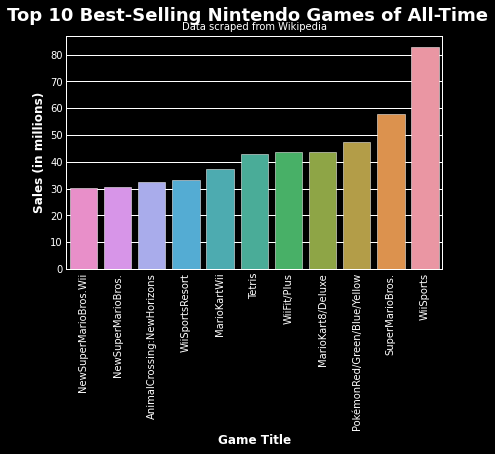

In [410]:
plt.style.use('dark_background')
sns.barplot(x = 'Title', y = 'Sales_in_millions', data = all_nintendo_consoles, edgecolor='white')
plt.suptitle('Top 10 Best-Selling Nintendo Games of All-Time', weight='bold', color = 'white').set_fontsize(18)
plt.title('Data scraped from Wikipedia', color = 'white').set_fontsize(10)
plt.xlabel('Game Title', weight = 'bold', color = 'white')
plt.ylabel('Sales (in millions)', weight = 'bold', color = 'white')
plt.xticks(rotation=90, color = 'white')
plt.yticks(color = 'white')
plt.gca().invert_xaxis()

#### Aside from Wii titles and Mario games, tetris has an impressive amount of sales for a vintage title, with over 40 million copies sold since its release in the early 1980s. 

In [332]:
all_consoles = pd.read_sql(''' SELECT Title, Platform, Sales_in_millions
                               FROM best_selling_video_games
                               GROUP BY Platform
                               ORDER BY Sales_in_millions DESC
                               LIMIT 11''', switch_conn)
all_consoles

,Title,Platform,Sales_in_millions
0,Minecraft,Multi-platform,200.00
1,Tetris,Mobile,100.00
2,WiiSports,Wii,82.90
3,SuperMarioBros.,NES/Arcade,58.00
4,PokémonRed/Green/Blue/Yellow,GameBoy/Color,47.52
5,MarioKart8/Deluxe,WiiU/Switch,43.84
6,Tetris,GameBoy/NES,43.00
7,AnimalCrossing:NewHorizons,NintendoSwitch,32.63
8,NewSuperMarioBros.,NintendoDS,30.80
9,PokémonGold/Silver/Crystal,GameBoyColor,29.49


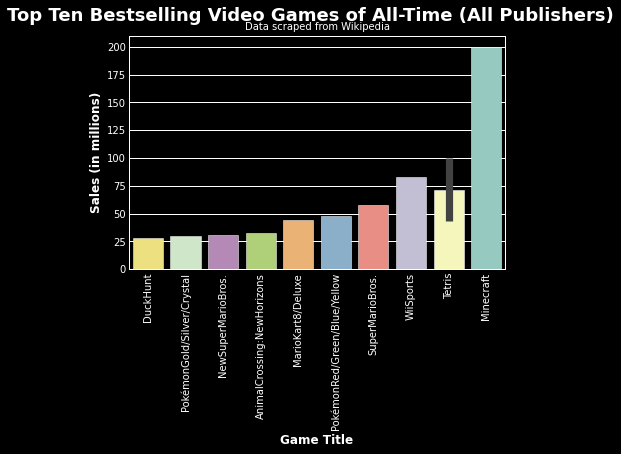

In [459]:
sns.barplot(x = 'Title', y = 'Sales_in_millions', data = all_consoles, edgecolor='white')
plt.suptitle('Top Ten Bestselling Video Games of All-Time (All Publishers)', weight='bold').set_fontsize(18)
plt.title('Data scraped from Wikipedia').set_fontsize(10)
plt.xlabel('Game Title', weight = 'bold', color = 'white')
plt.ylabel('Sales (in millions)', weight = 'bold', color = 'white')
plt.xticks(rotation=90, color = 'white')
plt.yticks(color = 'white')
plt.gca().invert_xaxis()

#### When we broaden the query to include non-Nintendo games, Minecraft and Tetris lead the market with over 100 million copies sold each. Tetris has sold approximately 100 million copies while Minecraft has sold 200 million copies. Both games, mobile releases, paved the way for future mobile hits such as Fortnite, which has since accumulated 350 million active users. 

# Conclusion

#### Video games occupy a particularly lucrative market space because while new releases can entice new players, established franchises like Mario and Pokémon can leverage nostalgia to maintain multi-generational fanbases. Even after comparing Nintendo sales to other consoles and mobile platforms, it is evident that Nintendo retains its spot as one of the 'big three' gaming developers/publishers and that competitors must closely monitor Nintendo's releases of versatile systems like the 3DS and Switch (and accompanying titles) in order to remain competitive in the console gaming sector. 